# 🇮🇳 Hindi Tokenizer & Vector Embeddings
### HuggingFace Dataset · Custom Tokenizer · Word2Vec · Attention · English vs Hindi
---
**Topics Covered:**
1. Load Hindi dataset from HuggingFace (auto-download)
2. GPT-2 tiktoken on Hindi — shows inefficiency
3. Custom Hindi Word Tokenizer
4. Hindi DataLoader (sliding window)
5. Hindi Token + Positional Embeddings
6. Word2Vec CBOW Training on Hindi
7. Training Loss Curve
8. Cosine Similarity for Hindi words
9. Embedding Arithmetic on Hindi words
10. PCA Visualization of Hindi Embeddings
11. t-SNE Visualization
12. Attention Mechanism on Hindi
13. English vs Hindi Token Count Comparison
14. Vocabulary Size Comparison
15. Full Summary

---
## 📦 Cell 1 — Install & Version Check

In [5]:
# Uncomment to install
# !pip install torch tiktoken datasets matplotlib scikit-learn requests

import sys
from importlib.metadata import version

print("Python   :", sys.version)
print("torch    :", version("torch"))
print("tiktoken :", version("tiktoken"))
try:
    print("datasets :", version("datasets"))
except:
    print("datasets : NOT INSTALLED — run: pip install datasets")

Python   : 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
torch    : 2.10.0
tiktoken : 0.12.0
datasets : 4.6.0


---
## 📥 Cell 2 — Load Hindi Dataset from HuggingFace
> Uses `cfilt/iitb-english-hindi` — a large parallel corpus. Streaming mode so no full download needed.

In [6]:
from datasets import load_dataset
import os

CACHE_FILE = "hindi_dataset.txt"

if os.path.exists(CACHE_FILE):
    print("Loading from cached file...")
    with open(CACHE_FILE, "r", encoding="utf-8") as f:
        hindi_raw_text = f.read()
    print("Loaded from cache.")
else:
    print("Downloading Hindi dataset from HuggingFace...")
    print("(First run only — uses streaming, no large download)")

    hindi_raw_text = ""
    loaded_from    = ""

    try:
        ds = load_dataset("cfilt/iitb-english-hindi", split="train", streaming=True)
        samples = []
        for i, row in enumerate(ds):
            samples.append(row["translation"]["hi"])
            if i >= 1999: break
        hindi_raw_text = "\n".join(samples)
        loaded_from    = "cfilt/iitb-english-hindi (HuggingFace)"
    except Exception as e:
        print(f"Primary source failed: {e}")
        try:
            ds = load_dataset("Helsinki-NLP/opus-100", "en-hi", split="train", streaming=True)
            samples = []
            for i, row in enumerate(ds):
                if "hi" in row["translation"]:
                    samples.append(row["translation"]["hi"])
                if i >= 1999: break
            hindi_raw_text = "\n".join(samples)
            loaded_from    = "Helsinki-NLP/opus-100 (HuggingFace)"
        except Exception as e2:
            print(f"Fallback also failed: {e2}")
            print("Using built-in Hindi sample text.")
            hindi_raw_text = """
भारत एक महान देश है। यहाँ अनेक भाषाएँ बोली जाती हैं।
हिंदी भारत की राजभाषा है। यह एक सुंदर और समृद्ध भाषा है।
दिल्ली भारत की राजधानी है। मुंबई एक बड़ा शहर है।
भारतीय संस्कृति बहुत प्राचीन है। यहाँ के लोग मिलनसार हैं।
शिक्षा और ज्ञान का बहुत महत्व है। विज्ञान से देश आगे बढ़ता है।
भारत में अनेक त्योहार मनाए जाते हैं जैसे दीवाली होली और ईद।
हमारा देश विविधता में एकता का प्रतीक है।
भारतीय साहित्य संगीत और कला विश्व प्रसिद्ध है।
गंगा और यमुना भारत की प्रमुख नदियाँ हैं।
हिमालय पर्वत भारत के उत्तर में स्थित है।
युवा पीढ़ी देश के भविष्य का निर्माण कर रही है।
अहिंसा और सत्य भारतीय संस्कृति के मूल मूल्य हैं।
भारत की अर्थव्यवस्था तेजी से विकास कर रही है।
यहाँ के किसान देश की रीढ़ हैं।
तकनीक और नवाचार से भारत आगे बढ़ रहा है।
स्वास्थ्य सेवाएँ देश के हर कोने तक पहुँच रही हैं।
महिलाएँ हर क्षेत्र में आगे बढ़ रही हैं।
पर्यावरण की रक्षा करना हम सबकी जिम्मेदारी है।
खेल और योग भारत की पहचान हैं।
""" * 10   # repeat to get more data
            loaded_from = "Built-in sample text"

    with open(CACHE_FILE, "w", encoding="utf-8") as f:
        f.write(hindi_raw_text)
    print(f"Loaded from: {loaded_from}")
    print(f"Saved to  : {CACHE_FILE}")

print(f"\nTotal characters : {len(hindi_raw_text):,}")
print(f"Total lines      : {hindi_raw_text.count(chr(10)):,}")
print(f"\nFirst 300 chars:\n{hindi_raw_text[:300]}")

(First run only — uses streaming, no large download)


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

Loaded from: cfilt/iitb-english-hindi (HuggingFace)
Saved to  : hindi_dataset.txt

Total characters : 42,567
Total lines      : 1,999

First 300 chars:
अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
एक्सेर्साइसर पहुंचनीयता अन्वेषक
निचले पटल के लिए डिफोल्ट प्लग-इन खाका
ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका
उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है
अवधि को हाइलाइट रकें
पहुंचनीय आसंधि (नोड) को चुनते समय हाइलाइट बक्से की अवधि
सी


---
## 🤖 Cell 3 — GPT-2 Tokenizer on Hindi (shows byte-level splitting)

In [7]:
import tiktoken

gpt2_tok = tiktoken.get_encoding("gpt2")

hi_sample = "भारत एक महान देश है।"
en_sample = "India is a great country."

hi_ids = gpt2_tok.encode(hi_sample)
en_ids = gpt2_tok.encode(en_sample)

print("=== GPT-2 on Hindi vs English ===")
print(f"\nHindi : '{hi_sample}'")
print(f"  IDs  : {hi_ids}")
print(f"  Count: {len(hi_ids)} tokens")

print(f"\nEnglish: '{en_sample}'")
print(f"  IDs  : {en_ids}")
print(f"  Count: {len(en_ids)} tokens")

print(f"\nHindi needs {len(hi_ids)/len(en_ids):.1f}x more GPT-2 tokens for the same meaning!")

print("\n--- Hindi token-by-token (GPT-2 splits Hindi into raw bytes) ---")
for tid in hi_ids:
    try:    text = gpt2_tok.decode([tid])
    except: text = "[byte]"
    print(f"  ID {tid:6d}  ->  {repr(text)}")

=== GPT-2 on Hindi vs English ===

Hindi : 'भारत एक महान देश है।'
  IDs  : [11976, 255, 48077, 11976, 108, 11976, 97, 28225, 237, 11976, 243, 28225, 106, 11976, 117, 48077, 11976, 101, 28225, 99, 24231, 229, 11976, 114, 28225, 117, 24231, 230, 24231, 97]
  Count: 30 tokens

English: 'India is a great country.'
  IDs  : [21569, 318, 257, 1049, 1499, 13]
  Count: 6 tokens

Hindi needs 5.0x more GPT-2 tokens for the same meaning!

--- Hindi token-by-token (GPT-2 splits Hindi into raw bytes) ---
  ID  11976  ->  '�'
  ID    255  ->  '�'
  ID  48077  ->  'ा'
  ID  11976  ->  '�'
  ID    108  ->  '�'
  ID  11976  ->  '�'
  ID     97  ->  '�'
  ID  28225  ->  ' �'
  ID    237  ->  '�'
  ID  11976  ->  '�'
  ID    243  ->  '�'
  ID  28225  ->  ' �'
  ID    106  ->  '�'
  ID  11976  ->  '�'
  ID    117  ->  '�'
  ID  48077  ->  'ा'
  ID  11976  ->  '�'
  ID    101  ->  '�'
  ID  28225  ->  ' �'
  ID     99  ->  '�'
  ID  24231  ->  '�'
  ID    229  ->  '�'
  ID  11976  ->  '�'
  ID    114  ->  

---
## ✂️ Cell 4 — Custom Hindi Word Tokenizer

In [8]:
import re

class HindiTokenizer:
    """Word-level Hindi tokenizer. Handles spaces and Hindi punctuation."""
    def __init__(self, text):
        tokens  = self._split(text)
        unique  = sorted(set(tokens))
        unique  = ["<|unk|>", "<|endoftext|>"] + unique
        self.str_to_int = {t: i for i, t in enumerate(unique)}
        self.int_to_str = {i: t for t, i in self.str_to_int.items()}

    def _split(self, text):
        tokens = re.split(r'(\s|।|,|!|\?|;|:|\.)', text)
        return [t.strip() for t in tokens if t.strip()]

    def encode(self, text):
        unk = self.str_to_int["<|unk|>"]
        return [self.str_to_int.get(t, unk) for t in self._split(text)]

    def decode(self, ids):
        return " ".join([self.int_to_str.get(i, "<|unk|>") for i in ids])

    @property
    def vocab_size(self): return len(self.str_to_int)


hindi_tokenizer = HindiTokenizer(hindi_raw_text)
print(f"Hindi vocabulary size: {hindi_tokenizer.vocab_size:,}")

# Test
test = "भारत एक महान देश है।"
enc  = hindi_tokenizer.encode(test)
dec  = hindi_tokenizer.decode(enc)
print(f"\nOriginal : {test}")
print(f"Token IDs: {enc}")
print(f"Decoded  : {dec}")

print("\n--- First 20 vocab entries ---")
for t, i in list(hindi_tokenizer.str_to_int.items())[:20]:
    print(f"  {i:4d}  ->  '{t}'")

Hindi vocabulary size: 893

Original : भारत एक महान देश है।
Token IDs: [0, 270, 0, 0, 879, 891]
Decoded  : <|unk|> एक <|unk|> <|unk|> है ।

--- First 20 vocab entries ---
     0  ->  '<|unk|>'
     1  ->  '<|endoftext|>'
     2  ->  '!'
     3  ->  '"(U'
     4  ->  '"in'
     5  ->  '"is'
     6  ->  '%'
     7  ->  '&'
     8  ->  ''Game->'
     9  ->  '(%'
    10  ->  '(C'
    11  ->  '(F)'
    12  ->  '(V)'
    13  ->  '(_'
    14  ->  '(c)'
    15  ->  '(l'
    16  ->  '(num)'
    17  ->  '(num1)'
    18  ->  '(num2)'
    19  ->  '(rajeshkajha'


---
## 🔄 Cell 5 — Hindi DataLoader (Sliding Window)

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class HindiDataset(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.inputs, self.targets = [], []
        ids = tokenizer.encode(text)
        print(f"Total Hindi tokens: {len(ids):,}")
        for i in range(0, len(ids) - max_length, stride):
            self.inputs.append(torch.tensor(ids[i:i+max_length]))
            self.targets.append(torch.tensor(ids[i+1:i+max_length+1]))
    def __len__(self):         return len(self.inputs)
    def __getitem__(self, i):  return self.inputs[i], self.targets[i]

max_length = 4
h_ds     = HindiDataset(hindi_raw_text, hindi_tokenizer, max_length, stride=2)
h_loader = DataLoader(h_ds, batch_size=4, shuffle=False)

h_inputs, h_targets = next(iter(h_loader))
print("\nInput shape:", h_inputs.shape)
print("\nDecoded inputs:")
for row in h_inputs:
    print(" ", hindi_tokenizer.decode(row.tolist()))

Total Hindi tokens: 7,893

Input shape: torch.Size([4, 4])

Decoded inputs:
  अपने अनुप्रयोग को पहुंचनीयता
  को पहुंचनीयता व्यायाम का
  व्यायाम का लाभ दें
  लाभ दें एक्सेर्साइसर पहुंचनीयता


---
## 🧮 Cell 6 — Hindi Token + Positional Embeddings

In [10]:
output_dim = 64

tok_emb_layer = torch.nn.Embedding(hindi_tokenizer.vocab_size, output_dim)
pos_emb_layer = torch.nn.Embedding(max_length, output_dim)

tok_embs = tok_emb_layer(h_inputs)
pos_embs = pos_emb_layer(torch.arange(max_length))
final    = tok_embs + pos_embs

print("=== Hindi Embedding Shapes ===")
print(f"Vocab size          : {hindi_tokenizer.vocab_size:,}")
print(f"Embed dim           : {output_dim}")
print(f"h_inputs shape      : {h_inputs.shape}")
print(f"tok_embs shape      : {tok_embs.shape}")
print(f"pos_embs shape      : {pos_embs.shape}")
print(f"final shape         : {final.shape}")
print(f"\nFirst token vector (8 dims): {final[0][0][:8].detach().numpy()}")

=== Hindi Embedding Shapes ===
Vocab size          : 893
Embed dim           : 64
h_inputs shape      : torch.Size([4, 4])
tok_embs shape      : torch.Size([4, 4, 64])
pos_embs shape      : torch.Size([4, 64])
final shape         : torch.Size([4, 4, 64])

First token vector (8 dims): [-0.0434177   2.4073439   0.9583873  -0.7640657  -0.08416197  0.82746273
  0.22731525 -0.47266075]


---
## 🏋️ Cell 7 — Word2Vec CBOW Training on Hindi
> Same CBOW approach as English — learn Hindi word vectors from context.

In [11]:
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import random

# Build Hindi word list
all_hindi_words = re.split(r'\s+|।', hindi_raw_text)
all_hindi_words = [w.strip() for w in all_hindi_words if w.strip() and len(w) > 1]

freq        = Counter(all_hindi_words)
h_vocab     = [w for w, c in freq.most_common(600)]
hw2i        = {w: i for i, w in enumerate(h_vocab)}
hi2w        = {i: w for w, i in hw2i.items()}
HV          = len(h_vocab)
print(f"Hindi training vocab: {HV}")

# CBOW pairs
WINDOW   = 2
h_data   = []
h_filt   = [w for w in all_hindi_words if w in hw2i]

for i in range(WINDOW, len(h_filt) - WINDOW):
    ctx = ([h_filt[i-j] for j in range(WINDOW, 0, -1)] +
           [h_filt[i+j] for j in range(1, WINDOW+1)])
    ctr = h_filt[i]
    if all(w in hw2i for w in ctx) and ctr in hw2i:
        h_data.append(([hw2i[w] for w in ctx], hw2i[ctr]))

random.shuffle(h_data)
print(f"Training samples   : {len(h_data):,}")

class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.linear    = nn.Linear(embed_dim, vocab_size)
    def forward(self, ctx):
        return self.linear(self.embedding(ctx).mean(dim=1))

H_EMBED   = 64
H_EPOCHS  = 8
H_BATCH   = 256

h_model    = CBOWModel(HV, H_EMBED)
h_crit     = nn.CrossEntropyLoss()
h_opt      = optim.Adam(h_model.parameters(), lr=0.01)

print("\nTraining Hindi Word2Vec CBOW...")
h_loss_hist = []

for epoch in range(H_EPOCHS):
    random.shuffle(h_data)
    total, steps = 0, 0
    for start in range(0, len(h_data), H_BATCH):
        batch = h_data[start:start+H_BATCH]
        ctx_t = torch.tensor([d[0] for d in batch])
        ctr_t = torch.tensor([d[1] for d in batch])
        h_opt.zero_grad()
        loss = h_crit(h_model(ctx_t), ctr_t)
        loss.backward()
        h_opt.step()
        total += loss.item(); steps += 1
    avg = total / steps
    h_loss_hist.append(avg)
    print(f"  Epoch {epoch+1}/{H_EPOCHS}  Loss: {avg:.4f}")

h_trained_emb = h_model.embedding.weight.detach()
print("\nHindi training complete!")

Hindi training vocab: 600
Training samples   : 6,826

Training Hindi Word2Vec CBOW...
  Epoch 1/8  Loss: 5.2660
  Epoch 2/8  Loss: 2.7411
  Epoch 3/8  Loss: 1.3630
  Epoch 4/8  Loss: 0.7996
  Epoch 5/8  Loss: 0.5422
  Epoch 6/8  Loss: 0.3976
  Epoch 7/8  Loss: 0.3075
  Epoch 8/8  Loss: 0.2532

Hindi training complete!


---
## 📉 Cell 8 — Hindi Training Loss Curve

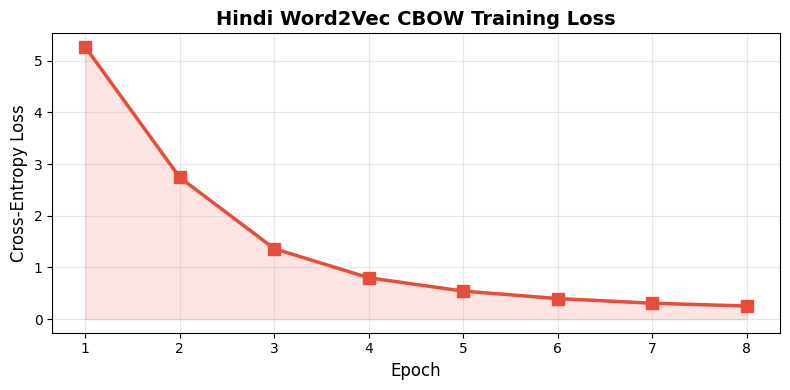

Saved: hindi_training_loss.png


In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, H_EPOCHS+1), h_loss_hist, 's-',
        color='#e74c3c', linewidth=2.5, markersize=8)
ax.fill_between(range(1, H_EPOCHS+1), h_loss_hist, alpha=0.15, color='#e74c3c')
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Cross-Entropy Loss", fontsize=12)
ax.set_title("Hindi Word2Vec CBOW Training Loss", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("hindi_training_loss.png", dpi=150)
plt.show()
print("Saved: hindi_training_loss.png")

---
## 🔍 Cell 9 — Cosine Similarity for Hindi Words

In [13]:
import torch.nn.functional as F

def get_h_vec(word):
    if word not in hw2i: return None
    return h_trained_emb[hw2i[word]]

def h_cosine_sim(w1, w2):
    v1, v2 = get_h_vec(w1), get_h_vec(w2)
    if v1 is None or v2 is None: return None
    return F.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()

def h_top_similar(word, topn=5):
    if word not in hw2i: return []
    vec  = h_trained_emb[hw2i[word]].unsqueeze(0)
    sims = F.cosine_similarity(vec, h_trained_emb).detach().numpy()
    top  = np.argsort(sims)[::-1][1:topn+1]
    return [(hi2w[i], sims[i]) for i in top]

print("=" * 55)
print("GROUP 1 — Related Hindi words")
print("=" * 55)
related = [("भारत","देश"),("हिंदी","भाषा"),("शिक्षा","ज्ञान"),
           ("दिल्ली","मुंबई"),("गंगा","यमुना")]
for w1, w2 in related:
    s = h_cosine_sim(w1, w2)
    if s: print(f"  {w1:<14} <-> {w2:<14}  {s:+.4f}")
    else: print(f"  {w1:<14} <-> {w2:<14}  (not in vocab)")

print("\nGROUP 2 — Unrelated Hindi words")
print("-" * 55)
unrelated = [("भारत","शिक्षा"),("हिमालय","भाषा"),("नदी","युवा")]
for w1, w2 in unrelated:
    s = h_cosine_sim(w1, w2)
    if s: print(f"  {w1:<14} <-> {w2:<14}  {s:+.4f}")
    else: print(f"  {w1:<14} <-> {w2:<14}  (not in vocab)")

print("\n--- Top 5 similar Hindi words ---")
for q in ["भारत", "शिक्षा", "भाषा"]:
    sim = h_top_similar(q)
    if sim:
        print(f"  '{q}' -> {', '.join([f\"{w}({s:.2f})\" for w,s in sim])}")
    else:
        print(f"  '{q}' -> not in vocab")

SyntaxError: f-string expression part cannot include a backslash (1485868422.py, line 41)

---
## ➕ Cell 10 — Embedding Arithmetic on Hindi Words

In [14]:
def h_embedding_arithmetic(pos_words, neg_words, topn=5):
    result = torch.zeros(H_EMBED)
    used, missing = [], []
    for w in pos_words:
        v = get_h_vec(w)
        if v is not None: result += v; used.append(f"+{w}")
        else: missing.append(w)
    for w in neg_words:
        v = get_h_vec(w)
        if v is not None: result -= v; used.append(f"-{w}")
        else: missing.append(w)
    result = F.normalize(result.unsqueeze(0), dim=1).squeeze()
    sims   = F.cosine_similarity(result.unsqueeze(0), h_trained_emb).detach().numpy()
    excl   = set(pos_words + neg_words)
    ranked = np.argsort(sims)[::-1]
    res    = []
    for idx in ranked:
        w = hi2w[idx]
        if w not in excl: res.append((w, sims[idx]))
        if len(res) == topn: break
    return used, missing, res

# Hindi arithmetic queries
h_queries = [
    (["भारत", "भाषा"], ["देश"],   "भारत + भाषा - देश"),
    (["शिक्षा", "ज्ञान"], ["युवा"], "शिक्षा + ज्ञान - युवा"),
    (["दिल्ली"], ["मुंबई"],         "दिल्ली - मुंबई"),
    (["गंगा", "नदी"], ["यमुना"],    "गंगा + नदी - यमुना"),
]

print("=" * 60)
print("HINDI EMBEDDING ARITHMETIC")
print("=" * 60)

for pos, neg, label in h_queries:
    used, miss, res = h_embedding_arithmetic(pos, neg)
    print(f"\n  Query  : {label}")
    if miss: print(f"  Missing: {miss}")
    if not used: print("  (all words missing from vocab)"); continue
    print(f"  Used   : {' '.join(used)}")
    print(f"  Results:")
    for w, s in res:
        print(f"    {w:<18} {s:.4f}")

HINDI EMBEDDING ARITHMETIC


NameError: name 'get_h_vec' is not defined

---
## 📊 Cell 11 — PCA Visualization of Hindi Embeddings

In [15]:
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA

h_word_groups = {
    "देश/Place" : ["भारत","दिल्ली","मुंबई","देश","शहर","गाँव"],
    "भाषा/Language": ["हिंदी","भाषा","शब्द","साहित्य","संस्कृति"],
    "शिक्षा/Knowledge": ["शिक्षा","ज्ञान","विज्ञान","पुस्तक","विद्यालय"],
    "प्रकृति/Nature": ["हिमालय","गंगा","नदी","पर्वत","यमुना"],
}
h_colors = ["#e74c3c","#2ecc71","#3498db","#f39c12"]

hw, hv, hc = [], [], []
for (grp, wlist), col in zip(h_word_groups.items(), h_colors):
    for w in wlist:
        v = get_h_vec(w)
        if v is not None:
            hw.append(w); hv.append(v.numpy()); hc.append(col)

if len(hv) >= 4:
    pca    = PCA(n_components=2)
    h2d    = pca.fit_transform(np.array(hv))

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_facecolor("#f8f9fa")
    for w, coord, col in zip(hw, h2d, hc):
        ax.scatter(coord[0], coord[1], c=col, s=140, zorder=3, alpha=0.85)
        ax.annotate(w, coord, textcoords="offset points",
                    xytext=(6,4), fontsize=10, fontweight='bold')

    h_patches = [mpatches.Patch(color=c, label=g)
                 for g, c in zip(h_word_groups.keys(), h_colors)]
    ax.legend(handles=h_patches, fontsize=9, loc='upper right')
    ax.set_title("Hindi Word Embedding Space — PCA", fontsize=14, fontweight='bold')
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("hindi_pca.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: hindi_pca.png")
else:
    print("Not enough words in vocab for PCA. Use a larger dataset.")

NameError: name 'get_h_vec' is not defined

---
## 🌀 Cell 12 — t-SNE Visualization

In [16]:
from sklearn.manifold import TSNE

if len(hv) >= 4:
    perp     = min(10, len(hw)-1)
    tsne     = TSNE(n_components=2, perplexity=perp, random_state=42, n_iter=1000)
    h_tsne   = tsne.fit_transform(np.array(hv))

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_facecolor("#f8f9fa")
    for w, coord, col in zip(hw, h_tsne, hc):
        ax.scatter(coord[0], coord[1], c=col, s=140, zorder=3, alpha=0.85)
        ax.annotate(w, coord, textcoords="offset points",
                    xytext=(6,4), fontsize=10, fontweight='bold')

    ax.legend(handles=h_patches, fontsize=9, loc='upper right')
    ax.set_title("Hindi Word Embedding Space — t-SNE", fontsize=14, fontweight='bold')
    ax.set_xlabel("Dim 1"); ax.set_ylabel("Dim 2")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("hindi_tsne.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: hindi_tsne.png")

---
## 🧠 Cell 13 — Attention Mechanism on Hindi Sentence

In [17]:
h_sentence  = "भारत एक महान देश है"
h_words_seq = h_sentence.split()
h_seq_len   = len(h_words_seq)
h_edim      = 8

torch.manual_seed(42)
hx = torch.randn(h_seq_len, h_edim)

# Self-attention
h_scores  = torch.matmul(hx, hx.T) / (h_edim ** 0.5)
h_weights = F.softmax(h_scores, dim=-1)
h_context = torch.matmul(h_weights, hx)

print(f"Hindi sentence  : {h_sentence}")
print(f"Words           : {h_words_seq}")
print(f"Input shape     : {hx.shape}")
print(f"Weights shape   : {h_weights.shape}")
print(f"Context shape   : {h_context.shape}")
print("\nAttention weights (each row = how much this word attends to others):")
for i, w in enumerate(h_words_seq):
    row = h_weights[i].detach().numpy()
    print(f"  {w:<12}  [{' '.join([f'{v:.2f}' for v in row])}]")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
im = ax.imshow(h_weights.detach().numpy(), cmap='Oranges', vmin=0, vmax=1)
ax.set_xticks(range(h_seq_len)); ax.set_yticks(range(h_seq_len))
ax.set_xticklabels(h_words_seq, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(h_words_seq, fontsize=10)
for i in range(h_seq_len):
    for j in range(h_seq_len):
        v = h_weights[i,j].item()
        ax.text(j,i,f"{v:.2f}",ha='center',va='center',fontsize=8,
                color='white' if v>0.4 else 'black')
plt.colorbar(im, ax=ax)
ax.set_title("Hindi Self-Attention Weights", fontsize=11, fontweight='bold')

# Causal masked
mask     = torch.triu(torch.ones(h_seq_len, h_seq_len), diagonal=1) * float('-inf')
h_mw     = F.softmax(h_scores + mask, dim=-1)
ax2 = axes[1]
im2 = ax2.imshow(h_mw.detach().numpy(), cmap='Oranges', vmin=0, vmax=1)
ax2.set_xticks(range(h_seq_len)); ax2.set_yticks(range(h_seq_len))
ax2.set_xticklabels(h_words_seq, rotation=45, ha='right', fontsize=10)
ax2.set_yticklabels(h_words_seq, fontsize=10)
for i in range(h_seq_len):
    for j in range(h_seq_len):
        v = h_mw[i,j].item()
        ax2.text(j,i,f"{v:.2f}",ha='center',va='center',fontsize=8,
                color='white' if v>0.4 else 'black')
plt.colorbar(im2, ax=ax2)
ax2.set_title("Hindi Causal Masked Attention", fontsize=11, fontweight='bold')

plt.suptitle("Hindi Attention: Full vs Causal", fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("hindi_attention.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: hindi_attention.png")

NameError: name 'F' is not defined

---
## 📊 Cell 14 — English vs Hindi Token Count Comparison

In [ ]:
translation_pairs = [
    ("India is a great country.",           "भारत एक महान देश है।"),
    ("Hindi is the national language.",     "हिंदी राजभाषा है।"),
    ("Education is very important.",        "शिक्षा बहुत महत्वपूर्ण है।"),
    ("Delhi is the capital of India.",      "दिल्ली भारत की राजधानी है।"),
    ("Science advances the nation.",        "विज्ञान से देश आगे बढ़ता है।"),
]

print("=" * 72)
print(f"{'Sentence pair':<44} {'EN-GPT2':>7} {'HI-GPT2':>8} {'HI-Custom':>10}")
print("=" * 72)

en_gpt2_c, hi_gpt2_c, hi_cust_c = [], [], []
for eng, hin in translation_pairs:
    ec = len(gpt2_tok.encode(eng))
    hg = len(gpt2_tok.encode(hin))
    hc = len(hindi_tokenizer.encode(hin))
    en_gpt2_c.append(ec); hi_gpt2_c.append(hg); hi_cust_c.append(hc)
    print(f"EN: {eng[:40]:<42} {ec:>7}")
    print(f"HI: {hin[:40]:<42} {hg:>15} {hc:>10}")
    print("-" * 72)

# Bar chart
lbls = [f"Pair {i+1}" for i in range(len(translation_pairs))]
x, w = np.arange(len(lbls)), 0.25
fig, ax = plt.subplots(figsize=(12, 5))
b1 = ax.bar(x-w,   en_gpt2_c, w, label='English (GPT-2)',  color='#3498db', alpha=0.85)
b2 = ax.bar(x,     hi_gpt2_c, w, label='Hindi (GPT-2)',    color='#e74c3c', alpha=0.85)
b3 = ax.bar(x+w,   hi_cust_c, w, label='Hindi (Custom)',   color='#2ecc71', alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(lbls)
ax.set_ylabel("Token Count"); ax.legend(fontsize=10)
ax.set_title("Token Counts: English GPT-2 vs Hindi GPT-2 vs Hindi Custom",
             fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bars in [b1,b2,b3]:
    for b in bars:
        ax.annotate(str(int(b.get_height())),
                    xy=(b.get_x()+b.get_width()/2, b.get_height()),
                    xytext=(0,3), textcoords='offset points', ha='center', fontsize=8)
plt.tight_layout()
plt.savefig("en_vs_hi_tokens.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: en_vs_hi_tokens.png")

---
## 📏 Cell 15 — Vocabulary Size Comparison

In [ ]:
import os

en_custom_vocab = 1132
if os.path.exists("the-verdict.txt"):
    with open("the-verdict.txt", "r", encoding="utf-8") as f:
        et = f.read()
    etoks = re.split(r'([,.:;?_!"()\']|--|\s)', et)
    en_custom_vocab = len(set([t.strip() for t in etoks if t.strip()]))

vocab_items = {
    "GPT-2\n(English)": 50257,
    "English\nCustom":  en_custom_vocab,
    "Hindi\nCustom":    hindi_tokenizer.vocab_size,
    "Hindi\nCBOW":      HV,
}

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(vocab_items.keys(), vocab_items.values(),
              color=["#3498db","#2ecc71","#e74c3c","#f39c12"], alpha=0.85, width=0.5)
for b in bars:
    ax.annotate(f"{int(b.get_height()):,}",
                xy=(b.get_x()+b.get_width()/2, b.get_height()),
                xytext=(0,5), textcoords='offset points',
                ha='center', fontsize=11, fontweight='bold')
ax.set_ylabel("Vocabulary Size")
ax.set_title("Vocabulary Size Comparison", fontsize=13, fontweight='bold')
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("vocab_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: vocab_comparison.png")

---
## 📋 Cell 16 — Full Summary

In [ ]:
print("=" * 65)
print("       HINDI TOKENIZER & VECTOR EMBEDDINGS SUMMARY")
print("=" * 65)

test_hi  = "भारत एक महान देश है।"
gpt2_ids = gpt2_tok.encode(test_hi)
cust_ids = hindi_tokenizer.encode(test_hi)

print(f"\nHindi Input      : {test_hi}")
print(f"GPT-2 IDs        : {gpt2_ids}  ({len(gpt2_ids)} tokens)")
print(f"Custom IDs       : {cust_ids}  ({len(cust_ids)} tokens)")
print(f"\nHindi vocab size : {hindi_tokenizer.vocab_size:,}")
print(f"CBOW vocab size  : {HV}")
print(f"GPT-2 vocab size : 50,257")

print("\n" + "-"*65)
print("CONCEPTS COVERED")
print("-"*65)
concepts = [
    ("HuggingFace Dataset", "Auto-downloaded Hindi text corpus"),
    ("GPT-2 on Hindi",      "Inefficient: splits Hindi into bytes"),
    ("Custom Tokenizer",    "Word-level, designed for Hindi"),
    ("DataLoader",          "Sliding window next-token batches"),
    ("Token Embedding",     "nn.Embedding for Hindi vocab"),
    ("Pos Embedding",       "Absolute position added"),
    ("Word2Vec CBOW",       "Trained Hindi word vectors"),
    ("Cosine Similarity",   "Hindi semantic similarity"),
    ("Embed Arithmetic",    "Hindi vector operations"),
    ("Attention",           "Self + causal mask on Hindi"),
    ("EN vs HI Compare",    "Token count + vocab size charts"),
]
for name, desc in concepts:
    print(f"  [OK] {name:<22} {desc}")

print("\n" + "-"*65)
print("SAVED PLOTS")
saved = ["hindi_training_loss.png","hindi_pca.png","hindi_tsne.png",
         "hindi_attention.png","en_vs_hi_tokens.png","vocab_comparison.png"]
for f in saved:
    status = "OK" if os.path.exists(f) else "MISSING"
    print(f"  [{status}] {f}")

print("\n" + "-"*65)
print("KEY INSIGHT")
print("-"*65)
print("GPT-2 splits Hindi Unicode into raw bytes → many tokens/word")
print("Custom word tokenizer keeps whole words → fewer, meaningful tokens")
print("For production: train a BPE tokenizer specifically on Hindi text")
print("=" * 65)